# KKBox Customer Segmentation Analysis

---

# Part 2: <font color=green>*Segmentation Analysis*</font>
Please refer to the following notebook for the initial Exploratory Data Analysis as this project builds on the previous Churn Prediction Project
- https://github.com/dangoML/Project-Portfolio/blob/master/KKBox%20Customer%20Churn%20Prediction/KKBox%20Churn%20-%20Part%202%20-%20EDA.ipynb

---

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Introduction - Why Do We Care About Customer Segmentation?

*Big Data will spell the death of customer segmentation and force the marketer to understand each customer as an individual within eighteen months, or risk being left in the dust.* -Ginni Rometty 

Customer segmentation is the practice of dividing a customer base into groups of individuals that are similar in specific ways relevant to marketing, such as age, gender, interests and spending habits. More importantly, it is about getting to know exactly Who your customer is. When looking into how to break down your customer base, there are several ways that we can go about this:
- Behavioral Data - engagement, platform
- Geographic Data - location
- Demographic Data - age, gender
- Motivation / Intenet - why do they use us? (psychographic data)
- Acquisition Source = paid, organic, referral

In essence, it all comes down to **Frequency of Use + How They Use + Why They Use = Customer Segment**. The intention of all of this is to identify the DNA and motivation behind each of our customers so we can continue to build our business on them efficiently. Due to the limited access to data, we will solely be focusing on deriving behavioral information.

## Import Data

#### - <font color=purple>*Import Data*</font> -

In [3]:
DRV_Jan2016_Clust = pd.read_csv('D:\J-5 Local\DRV_Jan2016_With_Cluster')

## Model Pre-Processing

#### - <font color=purple>*Remove Categoricals and Other Unimportant Features*</font> -

In [4]:
# Create list of Categorical feature names
cat_feats = ['is_auto_renew', 'total_spent_zero', 'city_agg', 'payment_method_agg', 'never_active_subscriber']

# Create list of Continuous feature names
cont_feats = [x for x in DRV_Jan2016_Clust.columns if x not in cat_feats]
cont_feats.remove('msno')
cont_feats.remove('is_churn')
cont_feats.remove('membership_expire_date')
cont_feats.remove('registration_init_time')
cont_feats.remove('city')
cont_feats.remove('bd')
cont_feats.remove('payment_method_id')
cont_feats.remove('is_net_paid_amount')
cont_feats.remove('registered_via')
cont_feats.remove('Cluster')

In [5]:
# Create list of all significant features
cont_feats_sig = cont_feats.copy()
cont_feats_sig.remove('total_secs_last_120')
cont_feats_sig.remove('total_secs_last_120_AVG')
cont_feats_sig.remove('DIFSTD_songs50_30_45_45_60')
cont_feats_sig.remove('Unnamed: 0')

#### - <font color=purple>*Split Up Features By Theme*</font> -

First, we will start by splitting up our features into themes to make our analysis more intuitive.

In [30]:
# Aggregate Activity Features
agg_total_feats = ['membership_length', 'total_songs', 'total_logins', 'sum_num_unq', 'sum_num_repeat', 'sum_over_50pec', 'sum_over_75pec', 'sum_over_985pec']

# Transaction Features
trans_cont_feats = ['total_transactions', 'total_spent', 'spent_per_logins', 'spent_per_song']
trans_cat_feats = ['is_net_paid_amount', 'is_auto_renew', 'total_spent_zero', 'registered_via']

## EDA on Clusters Groups

#### <font color=blue>Cluster Group vs Churn</font>

#### - <font color=purple>*Total and Relative Size of Clusters*</font> -

In [31]:
# Total and Relative Size of Cluses
clust_size = pd.DataFrame(DRV_Jan2016_Clust['Cluster'].value_counts())
clust_size['Relative Size'] = clust_size['Cluster'] / DRV_Jan2016_Clust.shape[0]
clust_size.columns = ['Cluster Size', 'Relative Size']
clust_size

,Cluster Size,Relative Size
1,290368,0.419668
0,285603,0.412781
2,100085,0.144653
3,15843,0.022898


- Cluster 0 and 1 make up over 80% of our train population. 
- With Cluster 3 being so small it leads me to believe that it maybe be an "outlier cluster". 
- K-Means is quite an efficient algorithm when it comes to handling outliers. Most of the time it will cluster outlier-observations into a single group. We will explore this further soon.

#### - <font color=purple>*Cluster Label vs Churn*</font> -

In [8]:
# create crosstab: Cluster vs Churn, also calculate % of User Churn per Cluster
count_table = pd.crosstab(DRV_Jan2016_Clust["Cluster"], DRV_Jan2016_Clust["is_churn"])
count_table['Is_Churn %'] = count_table[1] / (count_table[0] + count_table[1])
count_table

is_churn,0,1,Is_Churn %
Cluster,,,
0,280753,4850,0.016982
1,277337,13031,0.044878
2,98947,1138,0.011370
3,15714,129,0.008142


- Here we observe a significant difference between each of our cluster groups. 
- Cluster 0 and 1 are virtually the same sizes yet the latter has more than 2.5X the amount of churned users compared to the former.
- Although Cluster 0 and 2 have a similar relative rate of churn, I wonder if both of these groups have similarities in behavior.
- Cluster 3 didn't even break 1% in relative churn.

### <font color=blue>Cluster Group vs Aggregate Activity Features</font>

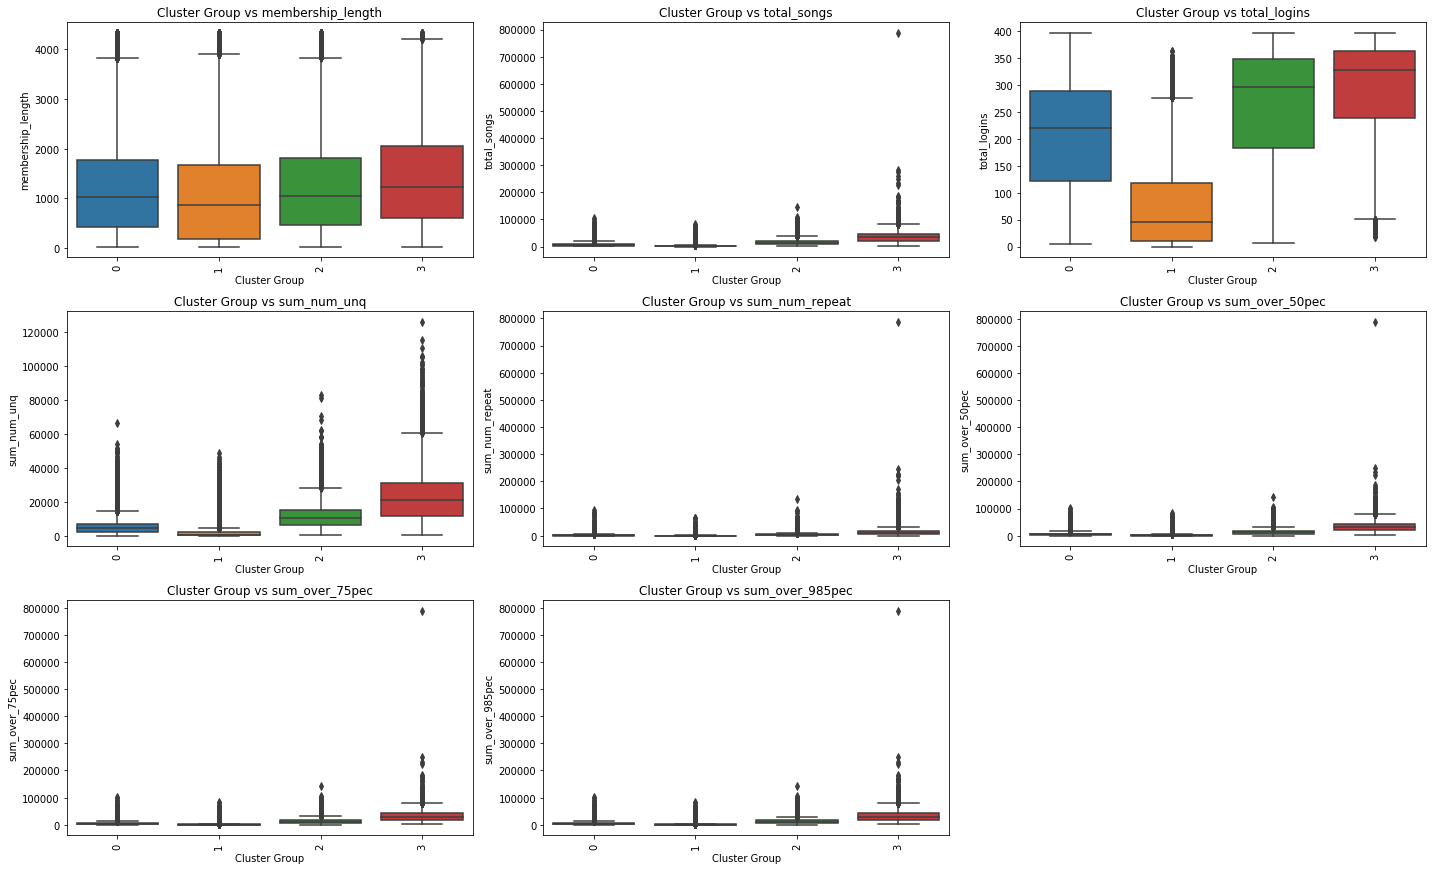

In [9]:
# Categorical TargetVar vs Cont_feats
plt.figure(figsize=(20,60))

for index, column in enumerate(agg_total_feats):
    plt.subplot(15,3,index+1)
    sns.boxplot(DRV_Jan2016_Clust['Cluster'],DRV_Jan2016_Clust[column])
    plt.title(f"Cluster Group vs {column}")
    plt.ylabel(column)
    plt.xlabel('Cluster Group')
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

- Although all clusters have significant differences across all plots, **Membership Length** seems to be more or less stable in terms of median values. This leads me to believe that ***activity*** is more import than ***tenure***.
- Making up almost half of the population, Cluster 1 users are the least active and performing the worst across categories. Cluster 3 users are the most active
- Clusters 0 and 2 users have clear but more subtle differences compared to the other two. Cluster 2 does edge out Cluster 0 in terms of activity but don't forget that there isn't much difference in terms of relative churn. 

In the next step, we will break these features up over different time intervals. Although I believe that there won't be much of a difference in behavior and distribution, we must always be thorough.

### <font color=blue>Cluster Group vs Aggregate Activity Time Interval Features</font>

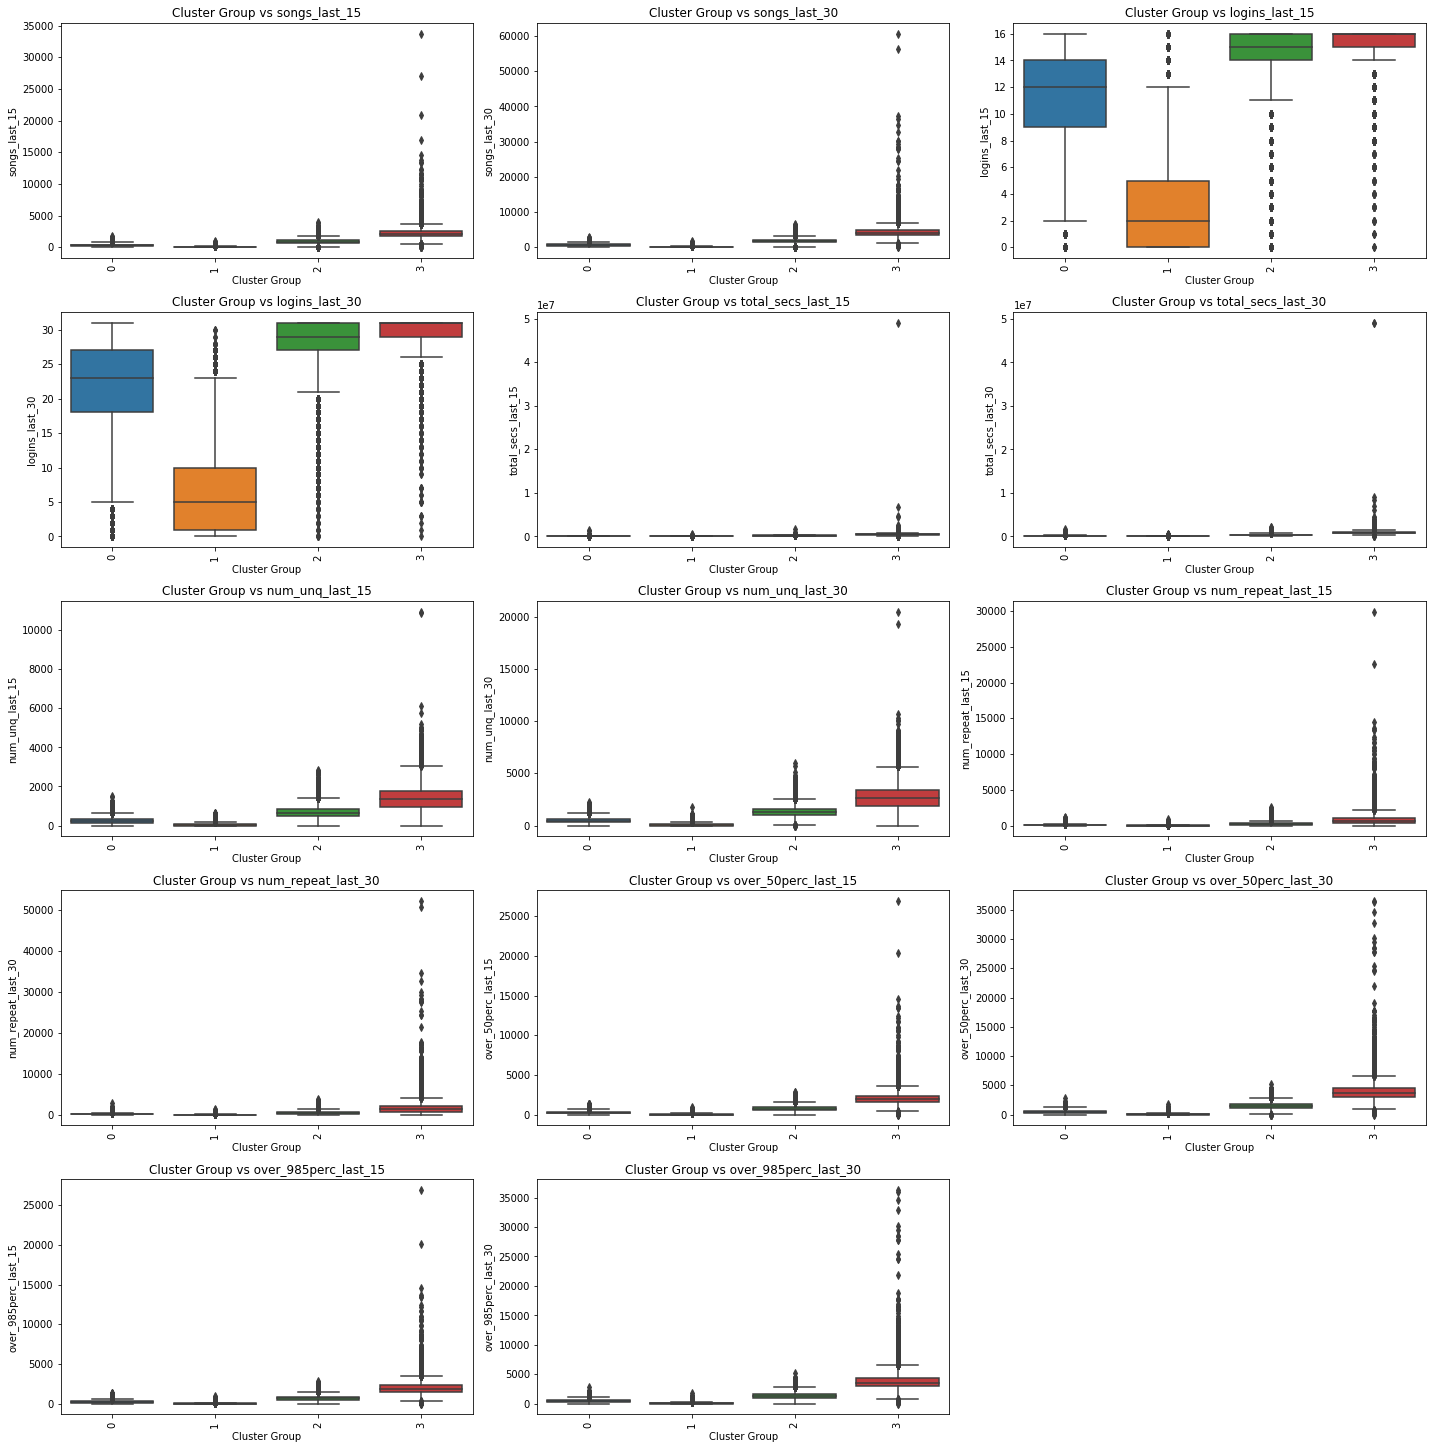

In [10]:
# Categorical TargetVar vs Cont_feats
plt.figure(figsize=(20,60))

for index, column in enumerate(agg_TI_feats):
    plt.subplot(15,3,index+1)
    sns.boxplot(DRV_Jan2016_Clust['Cluster'],DRV_Jan2016_Clust[column])
    plt.title(f"Cluster Group vs {column}")
    plt.ylabel(column)
    plt.xlabel('Cluster Group')
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

As expected, and now verified, there isn't much difference in user behavior over our various time intervals. This leads me to believe that each of these groups are quite consistent in their behavior over time.

### <font color=blue>Cluster Group vs Transaction Features</font>

#### - <font color=purple>*Cluster Group vs Continuous Transaction Features*</font> -

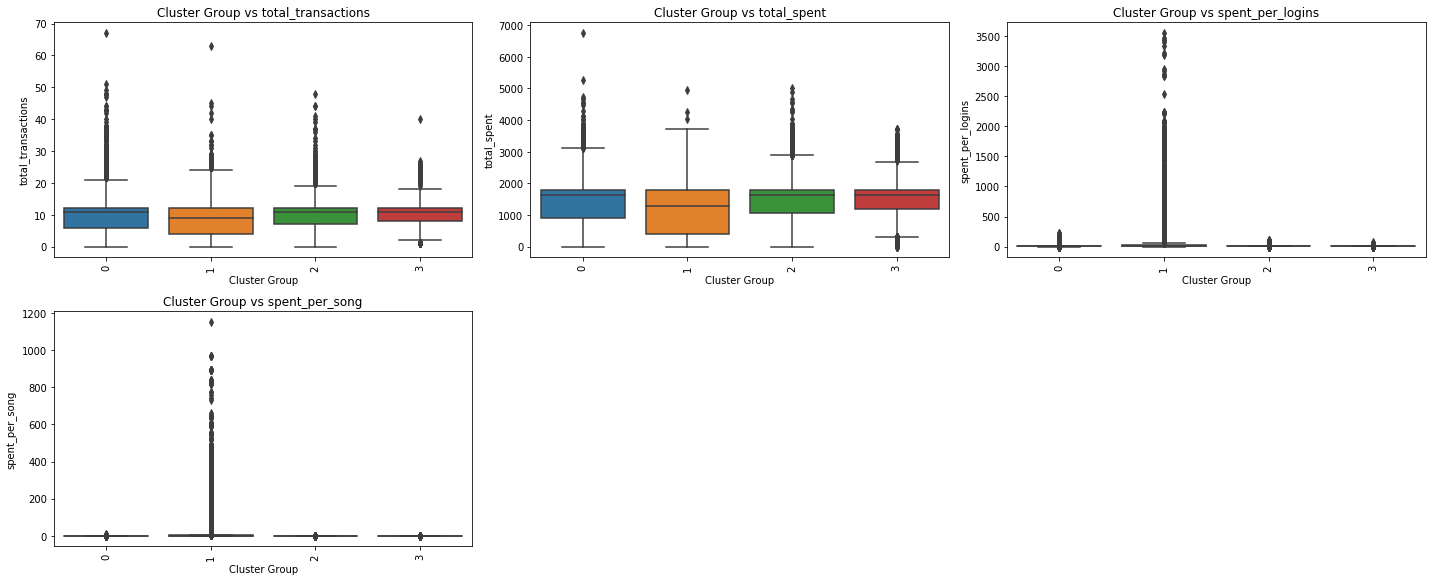

In [11]:
# Categorical TargetVar vs Cont_feats
plt.figure(figsize=(20,60))

for index, column in enumerate(trans_cont_feats):
    plt.subplot(15,3,index+1)
    sns.boxplot(DRV_Jan2016_Clust['Cluster'],DRV_Jan2016_Clust[column])
    plt.title(f"Cluster Group vs {column}")
    plt.ylabel(column)
    plt.xlabel('Cluster Group')
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

- It is surprising to see that Cluster 1 Users pay much less than their fellow peers. This is most likely due to having cheaper plan pricing and fewer transactions than the rest of the cohort. 
- Even more surprising is when taking into consideration both money spent and user activity, they are not getting their money's worth!! And they are paying less!!!
- Do discounts mean less user activity and churn? It is a fair question.

Let's also take a look at the total amount of money spent per group.

In [29]:
total_spend_clust = pd.DataFrame(DRV_Jan2016_Clust.groupby('Cluster')['total_spent'].sum())
total_spend_clust['Relative %'] = total_spend_clust['total_spent'] / total_spend_clust['total_spent'].sum()
total_spend_clust['Average Revenue Per User'] = total_spend_clust['total_spent'] / DRV_Jan2016_Clust.groupby('Cluster')['msno'].count()
total_spend_clust

,total_spent,Relative %,Average Revenue Per User
Cluster,,,
0,382016920,0.434302,1337.580207
1,335474332,0.381389,1155.341952
2,139062416,0.158095,1389.443133
3,23058533,0.026214,1455.439816


#### - <font color=purple>*Cluster Group vs Categorical Transaction Features*</font> -

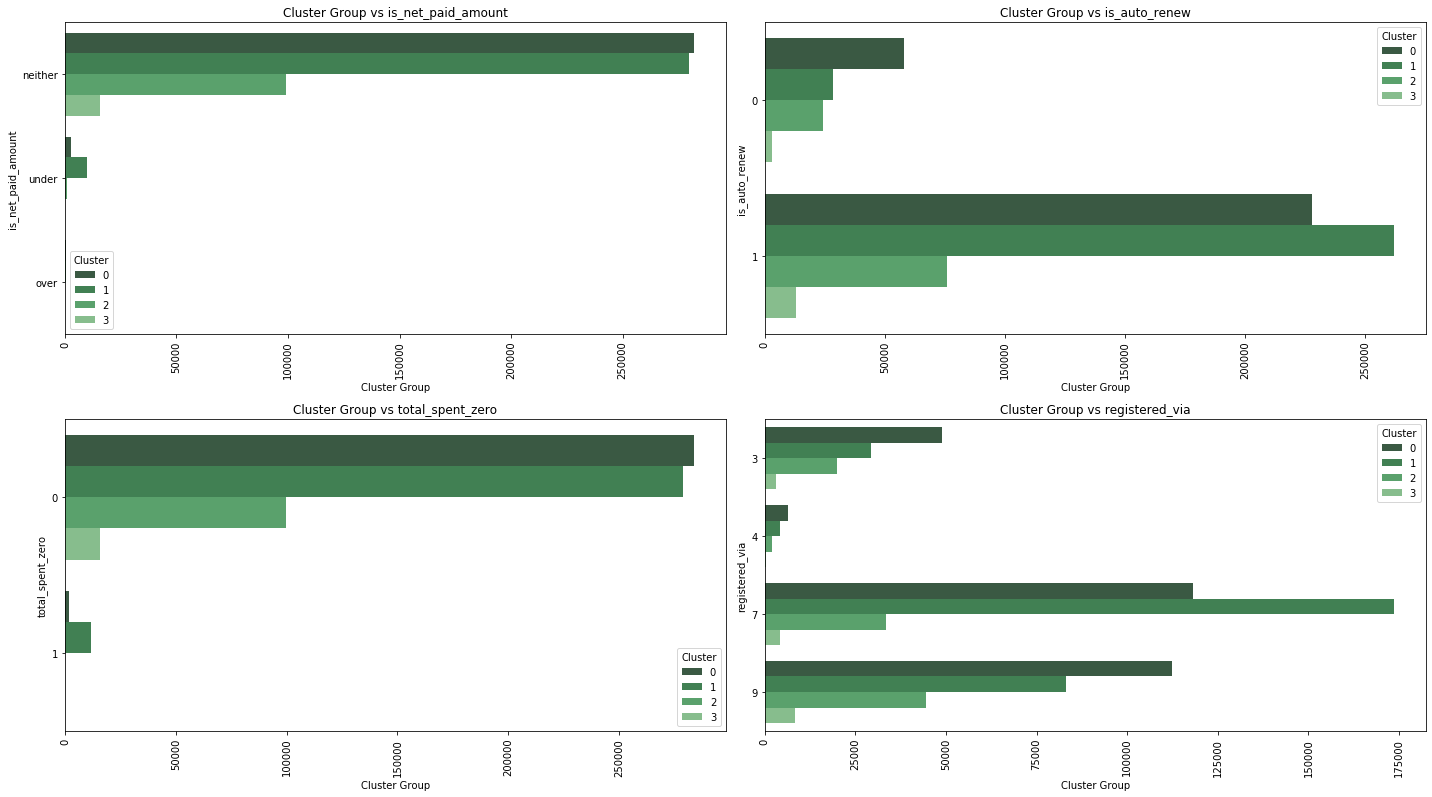

In [34]:
# Categorical TargetVar vs Cont_feats
plt.figure(figsize=(20,60))

for index, column in enumerate(trans_cat_feats):
    plt.subplot(11,2,index+1)
    sns.countplot(y=column, hue='Cluster', data=DRV_Jan2016_Clust, palette="Greens_d")
    plt.title(f"Cluster Group vs {column}")
    plt.ylabel(column)
    plt.xlabel('Cluster Group')
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

Although we can make out some differences, Let's translate these bar charts in to crosstab tables.

In [35]:
# Categorical TargetVar vs Cont_feats
plt.figure(figsize=(20,60))

for index, column in enumerate(trans_cat_feats):
    count_table = pd.crosstab(DRV_Jan2016_Clust["Cluster"], DRV_Jan2016_Clust[column])
    print(count_table)
    print('')
    

is_net_paid_amount  neither  over  under
Cluster                                 
0                    282183   553   2867
1                    279935   439   9994
2                     99139   156    790
3                     15728    18     97

is_auto_renew      0       1
Cluster                     
0              57734  227869
1              28447  261921
2              24170   75915
3               2866   12977

total_spent_zero       0      1
Cluster                        
0                 283895   1708
1                 278735  11633
2                  99861    224
3                  15833     10

registered_via      3     4       7       9
Cluster                                    
0               48825  6339  118139  112300
1               29370  4185  173654   83159
2               19966  2093   33467   44559
3                3058   194    4234    8357



<Figure size 1440x4320 with 0 Axes>

- Cluster 1 has way more users who underpay their current plan price compared to the rest.
- Cluster 1 also has more than 11.5K users who have NEVER paid a single cent!!
- registered_via is a bit of an ambigious feature and I will assume that it describes 'How' a user was onboarded. With said assumption and by looking at the revenue brought in per segment numbers, I would argue that the company should invest more on **3** and **9** acquisitions as they bring in more profitable users.

So in continuation of our previous question, ***Do discounts mean less user activity and churn?*** Let's look at both of these with points with respect to Churn.

#### - <font color=green>*Cluster Group 1: Total Spent Zero vs Churn*</font> -

In [14]:
# Total Spent Zero vs Churn - Crosstab Table
index = DRV_Jan2016_Clust[DRV_Jan2016_Clust["Cluster"] == 1]['total_spent_zero']
columns = DRV_Jan2016_Clust[DRV_Jan2016_Clust["Cluster"] == 1]['is_churn']
tsz_churn = pd.crosstab(index,columns)
tsz_churn['Is_Churn %'] = tsz_churn[1] / (tsz_churn[0] + tsz_churn[1])
tsz_churn

is_churn,0,1,Is_Churn %
total_spent_zero,,,
0,270184,8551,0.030678
1,7153,4480,0.385111


38.5% of all users in Cluster 1 who have never paid a single penny for the stream service, churned. 

#### - <font color=green>*Cluster Group 2: Over/Under/Neither Pay vs Churn*</font> -

In [15]:
# Total Spent Zero vs Churn - Crosstab Table
index = DRV_Jan2016_Clust[DRV_Jan2016_Clust["Cluster"] == 1]['is_net_paid_amount']
columns = DRV_Jan2016_Clust[DRV_Jan2016_Clust["Cluster"] == 1]['is_churn']
isnpa_churn = pd.crosstab(index,columns)
isnpa_churn['Is_Churn %'] = isnpa_churn[1] / (isnpa_churn[0] + isnpa_churn[1])
isnpa_churn

is_churn,0,1,Is_Churn %
is_net_paid_amount,,,
neither,270362,9573,0.034197
over,435,4,0.009112
under,6540,3454,0.345607


34.5% of all users in Cluster 1 who currently underpaid their plan price, churned. 

## Conclusion

I am very happy with the results of the cluster model as I felt that it did a great job capturing the differences amongst each of our customer segments. I would define these segments as follows:

***Cluster 3, The Power Users***

Small in numbers but Loyal, this segment of users was the most active across all metrics. As these users tend to have longer membership lengths than the others, their proportional churn was below 1%. This group also had the highest average revenue per user. 

***Cluster 2, Secondary Power Users***

In terms of activity, these users were a close second to our Power Users and contributed to roughly ~16% of the total observed revenue. Like our Cluster 0 users, they have a churn % sitting slightly above 1%. 

***Cluster 0, The Active Majority***

Coming in at third, in terms of activity, we have what we call 'The Active Majority'. Making up nearly 43% of our observed population these users are the strongest contributors to revenue making up 43% of total revenue. Although Cluster 2 users were more active, there was virtually no difference between them in terms of Churn % and Average Revenue Per User.

***Cluster 1, The Inactive Minority***

With the largest amount of churn compared to all other groups, we observed how this segment of customers is significantly less active than the rest of the other groups. What was interesting however was that these users were most likely to have received discounts on their subscriptions and yet many of them ended up churning. Even as we just saw in the previous section: ***34.5% of all users in Cluster 1 who currently underpaid their plan price, churned.*** This makes me question whether or not many of these people are even worth spending resources on and reinforces why Customer Lifetime Value is so important when determining who is worth going after.

I wish we had more data related to user demographics and how these users were acquired so we can have a better understanding of attribution. Given the current, and limited, dataset we were able to make strides on creating an initial customer segmentation model. In the next project, we will work on understanding Customer Lifetime Value and how it relates to these segments.